# Thesis: Inference and Predictive Modelling

In [2]:
"""
Import necessary packages

"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

#preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#models
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

import pytz

import seaborn as sns

sns.set_style(style = 'darkgrid')
sns.set_palette('deep')

In [3]:
"""
Auxiliary Functions
"""

def rem_col(df, x):
    return df.drop(columns = x, axis = 1)

# Data Importing

In [5]:
"""
Reading Datasets
"""
liquidated = pd.read_csv("tesi_liquidations.csv")[['project','block_time','liquidated_borrower','tx_hash']].dropna()
liquidated = liquidated[liquidated.project != 'IronBank'].reset_index(drop = True)
borrowings_liq = pd.read_csv("tesi_borrowing_transaction_liq_addresses.csv").dropna()

liquidated.block_time = liquidated.block_time.apply(lambda x: pd.to_datetime(x))
borrowings_liq.block_time = borrowings_liq.block_time.apply(lambda x: pd.to_datetime(x))



borrowers_by_plf = pd.read_csv("tesi_borrowers_by_plf.csv").reset_index(drop = True).sort_values(by = ['borrower','first_borrow'])
borrowers_distinct_asset_features = pd.read_csv("tesi_borrowers_distinct_asset_features.csv")

collateral_change = pd.read_csv("tesi_collateral_change_users.csv")
collateral_change_liq = pd.read_csv("tesi_collateral_change_liq.csv")

repayment_liq = pd.read_csv("tesi_repayment_liq_data.csv")
repayments = pd.read_csv("tesi_repayments_users.csv")

# Deal with Liquidated Addresses

In [6]:
"""
Keep only the first liquidation that an user has faced
"""

liq_min = liquidated[['liquidated_borrower','block_time']].groupby('liquidated_borrower').min().reset_index().rename(columns = {'block_time':'first_liq'})


liq_aux = pd.merge(liquidated, liq_min, left_on = 'liquidated_borrower', right_on = 'liquidated_borrower')
liq_aux['same'] = liq_aux.block_time == liq_aux.first_liq


liq_aux = liq_aux[liq_aux.same == True].reset_index(drop = True)
liq_aux = liq_aux[['liquidated_borrower','project','first_liq']].groupby('liquidated_borrower').min().reset_index()

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/internals/construction.py:791: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  subarr = construct_1d_object_array_from_listlike(subarr)


In [7]:
"""
Keep only users that have their first borrow in 2021
"""

borrowings_liq_aux = pd.merge(borrowings_liq, liq_aux[['liquidated_borrower','first_liq']], left_on = 'borrower', right_on = 'liquidated_borrower')
borrowings_liq_aux['keep_1'] = borrowings_liq_aux.block_time <= borrowings_liq_aux.first_liq

borrowings_liq_aux = borrowings_liq_aux[borrowings_liq_aux.project != 'MakerDAO'].reset_index(drop = True)

borrowings_liq_aux = borrowings_liq_aux[borrowings_liq_aux.keep_1 == True]

borrowers_from_2021 = borrowings_liq_aux[['borrower','block_time']].groupby('borrower').min()[['block_time']] >= '2021-01-01'
borrowers_from_2021 = borrowers_from_2021[borrowers_from_2021.block_time == True]

In [8]:
"""
Final Datasets for Liquidated Addresses
"""

borrowings_liq_2021 = borrowings_liq_aux[borrowings_liq_aux.borrower.isin(borrowers_from_2021.index)].reset_index(drop = True)

liq_2021 = liq_aux[liq_aux.liquidated_borrower.isin(borrowers_from_2021.index)]



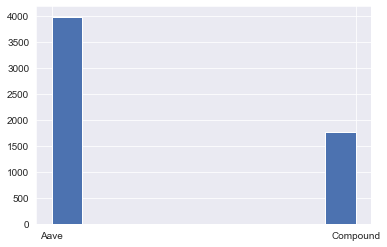

In [9]:
liq_2021.project.hist()

In [10]:
assert len(borrowings_liq_2021.borrower.unique()) == len(liq_2021.liquidated_borrower.unique())

# Dataset Creation

In [11]:
"""
Deal with Borrowers: keep those that were not liquidated, and those that first borrow was after 2021
"""
import pytz
now = datetime.now(tz=pytz.UTC)

borrowers_by_plf.first_borrow = borrowers_by_plf.first_borrow.apply(lambda x: pd.to_datetime(x))
borrowers_by_plf.last_borrow =  borrowers_by_plf.last_borrow.apply(lambda x: pd.to_datetime(x))

#Fliter out those that have been liquidated
borrowers_by_plf = borrowers_by_plf[~borrowers_by_plf.borrower.isin(liq_2021.liquidated_borrower.unique())]

#Filter out those whose first borrow is before 2021-01-01
borrowers_by_plf = borrowers_by_plf[borrowers_by_plf.first_borrow >= '2021-01-01'].reset_index(drop = True)

#Keep only fixed spread liquidation mechanisms borrowers

borrowers_by_plf = borrowers_by_plf[borrowers_by_plf.project.isin(np.array(['Compound', 'Aave']))].reset_index(drop = True)

borrowers_2021_not_liq = borrowers_by_plf.borrower.unique()

borrowers_by_plf = borrowers_by_plf.dropna().reset_index(drop = True)



In [12]:
borrowers_by_plf

,borrower,project,first_borrow,last_borrow,n_borrowings,total_borrowed,n_borrowings_of_eth,usd_borrows_of_eth,usd_borrows_of_aave,usd_borrows_of_dai,usd_borrows_of_usdc,usd_borrows_of_usdt,usd_borrows_of_btc,distinct_asset_borrowed_by_plf,n_of_protocols_used
0,\x00000000000cd56832ce5dfbcbff02e7ec639bc9,Aave,2021-05-29 15:35:30+00:00,2021-06-01 11:00:43+00:00,2,1.086699e+05,0,0.000000,0.0,0.0000,0.000000e+00,0.000000e+00,0.0,2,1
1,\x00000000009a41862f3b2b0c688b7c0d1940511e,Compound,2021-02-22 08:42:02+00:00,2021-10-03 18:30:27+00:00,5,4.005005e+04,0,0.000000,0.0,10053.6500,1.998006e+04,1.001634e+04,0.0,3,1
2,\x0000000002ce79aacd54227d2163ff3791338975,Aave,2022-03-28 01:22:53+00:00,2022-03-28 01:22:53+00:00,1,4.792272e+05,0,0.000000,0.0,0.0000,0.000000e+00,0.000000e+00,0.0,1,1
3,\x00000000032962b51589768828ad878876299e14,Aave,2022-08-04 14:09:26+00:00,2022-08-07 12:01:23+00:00,8,2.902693e+07,0,0.000000,0.0,0.0000,1.729359e+07,1.173334e+07,0.0,2,1
4,\x000000000a38444e0a6e37d3b630d7e855a7cb13,Aave,2021-07-25 16:01:24+00:00,2021-10-30 10:01:30+00:00,8,4.455738e+04,0,0.000000,0.0,0.0000,0.000000e+00,0.000000e+00,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40981,\xfffa889f71003f256f0e14b48e54fa2dad1f2ff0,Aave,2022-06-04 11:01:21+00:00,2022-06-04 11:01:21+00:00,1,5.008790e-01,0,0.000000,0.0,0.0000,5.008790e-01,0.000000e+00,0.0,1,1
40982,\xfffb40347816873ca038756cc87bc610144166b2,Aave,2022-05-07 05:11:36+00:00,2022-05-07 05:11:36+00:00,1,1.902647e+00,0,0.000000,0.0,0.0000,1.902647e+00,0.000000e+00,0.0,1,1
40983,\xfffbe00ed265804e6598ac6b804a6356508591c8,Compound,2021-05-04 07:14:02+00:00,2022-08-06 21:11:18+00:00,9,8.152008e+05,1,80288.650200,0.0,734912.1371,0.000000e+00,0.000000e+00,0.0,2,1
40984,\xfffcb3903a402b4669e232b53bc6bcebff6eb131,Aave,2022-06-08 18:54:41+00:00,2022-06-08 18:54:41+00:00,1,1.901735e+04,0,0.000000,0.0,0.0000,1.901735e+04,0.000000e+00,0.0,1,1


# Dataset Creation - Reference to Chapter 6.1 and 6.2

## 1. Borrowers Variables Creation

In [13]:
"""
Creation of (non-liquidated) borrowers dataset
"""
import pytz
now = datetime.now(tz=pytz.UTC)

borrow_df = borrowers_by_plf.sort_values(by = ['first_borrow'], ascending= True).groupby(['borrower'])[['first_borrow']].first()
borrow_df['last_borrow'] = borrowers_by_plf.sort_values(by = ['last_borrow'], ascending = True).groupby(['borrower'])[['last_borrow']].last()

borrow_df_liq = borrowings_liq_2021.sort_values(by = ['block_time'], ascending= True).groupby(['borrower'])[['block_time']].first().rename(columns = {'block_time':'first_borrow'})
borrow_df_liq['last_borrow'] = borrowings_liq_2021.sort_values(by = ['block_time'], ascending = True).groupby(['borrower'])[['block_time']].last()


borrow_df.last_borrow =  borrow_df.last_borrow.apply(lambda x: pd.to_datetime(x))
borrow_df.first_borrow = borrow_df.first_borrow.apply(lambda x: pd.to_datetime(x))

borrow_df['n_days_since_last_borrow'] = now - borrow_df.last_borrow 
borrow_df.n_days_since_last_borrow = borrow_df.n_days_since_last_borrow.apply(lambda x: x.days)

borrow_df_liq['n_days_since_last_borrow'] = now - borrow_df_liq.last_borrow
borrow_df_liq.n_days_since_last_borrow = borrow_df_liq.n_days_since_last_borrow.apply(lambda x: x.days)


In [14]:
"""
Features: aggregated total usd amount borrowed, top ten tokens among platform (liquidation group)
"""

#perc_stablecoin_borrowed
stablecoin = np.array(['USDC', 'DAI','USDT', 'TUSD', 'sUSD','GUSD','UST' ])

borrowings_liq_2021['stablecoin'] = borrowings_liq_2021.asset_symbol.isin(stablecoin)

total_borrowed = borrowings_liq_2021[['borrower','usd_value']].groupby('borrower').sum().rename(columns = {'usd_value':'total_borrowed'})

borrowers_features_unique_liq = pd.merge(borrow_df_liq, total_borrowed, left_index= True, right_index = True)


stablecoin_borrows = borrowings_liq_2021[['borrower','stablecoin','usd_value']].groupby(['borrower','stablecoin']).sum().reset_index().pivot(index = 'borrower', columns = 'stablecoin', values = 'usd_value').fillna(0).reset_index()

stablecoin_borrows.rename(columns = {False:'No_Stablecoin', True: 'Stablecoin'}, inplace = True)
borrowers_features_unique_liq = pd.merge(borrowers_features_unique_liq, stablecoin_borrows.set_index('borrower'), left_index= True, right_index = True)

borrowers_features_unique_liq['perc_stablecoin_borrowed'] = borrowers_features_unique_liq.Stablecoin / borrowers_features_unique_liq.total_borrowed

borrowers_features_unique_liq = borrowers_features_unique_liq.drop(columns= ['Stablecoin', 'No_Stablecoin', 'total_borrowed'], axis = 1)

In [15]:
"""
Features: aggregated total usd amount borrowed, top ten tokens among platform
"""

borrowers_features_unique = borrowers_by_plf[['borrower','usd_borrows_of_eth',
       'usd_borrows_of_aave', 'usd_borrows_of_dai', 'usd_borrows_of_usdc',
       'usd_borrows_of_usdt', 'usd_borrows_of_btc','total_borrowed','n_borrowings']].groupby('borrower').sum()

borrowers_features_unique['usd_borrows_stablecoin'] = borrowers_features_unique.usd_borrows_of_dai + borrowers_features_unique.usd_borrows_of_usdc + borrowers_features_unique.usd_borrows_of_usdt
borrowers_features_unique['perc_stablecoin_borrowed'] = borrowers_features_unique.usd_borrows_stablecoin / borrowers_features_unique.total_borrowed

borrowers_features_unique['usd_borrows_others'] = borrowers_features_unique.total_borrowed - borrowers_features_unique.usd_borrows_stablecoin
borrowers_features_unique['perc_others_borrowed'] = borrowers_features_unique.usd_borrows_others / borrowers_features_unique.total_borrowed

borrowers_features_unique[borrowers_features_unique.perc_others_borrowed < 0] = 0 #sometimes it's 0 due to usd and price variations


borrowers_features_unique = borrowers_features_unique.drop(columns = ['usd_borrows_of_eth',
       'usd_borrows_of_aave', 'usd_borrows_of_dai', 'usd_borrows_of_usdc',
       'usd_borrows_of_usdt', 'usd_borrows_of_btc','total_borrowed', 'perc_others_borrowed'], axis = 1)


In [16]:
"""
Distinct Asset Borrowed
"""

borrowings_features = pd.merge(borrowers_features_unique, borrowers_distinct_asset_features[['borrower', 'distinct_asset_borrowed_total']].set_index('borrower'), left_index = True, right_index = True)
borrowings_features_liq = pd.merge(borrowers_features_unique_liq,borrowers_distinct_asset_features[['borrower', 'distinct_asset_borrowed_total']].set_index('borrower'), left_index = True, right_index = True)


borrow_df = pd.merge(borrow_df, borrowings_features, left_index= True, right_index= True)
borrow_df_liq = borrowings_features_liq

In [17]:
"""
Variable for each PLF (which is not intended as a dummy)
"""

borrow_df = pd.merge(borrow_df, pd.get_dummies(borrowers_by_plf.set_index('borrower')[['project']], drop_first = False).groupby('borrower').sum(), left_index = True, right_index = True)

borrow_df_liq = pd.merge(borrow_df_liq, pd.get_dummies(borrowings_liq_2021.set_index('borrower')[['project']], drop_first = False).groupby('borrower').sum(), left_index = True, right_index = True)

borrow_df_liq.project_Aave = borrow_df_liq.project_Aave.apply(lambda x: 1 if x > 0 else 0)
borrow_df_liq.project_Compound = borrow_df_liq.project_Compound.apply(lambda x: 1 if x > 0 else 0)

In [18]:
"""
Insert Liquidation y variable
"""

borrow_df['y_liquidated'] = 0
borrow_df_liq['y_liquidated'] = 1

borrow_df = borrow_df[list(borrow_df_liq.columns)]


In [19]:
final_borrow = pd.concat([borrow_df, borrow_df_liq]).sort_values(by = 'first_borrow', ascending = False)
final_borrow

,first_borrow,last_borrow,n_days_since_last_borrow,perc_stablecoin_borrowed,distinct_asset_borrowed_total,project_Aave,project_Compound,y_liquidated
borrower,,,,,,,,
\x2d54703cd583b6f16e8474e995a5f3e96dbfe8fc,2022-09-03 00:05:24+00:00,2022-09-03 00:38:09+00:00,35,1.000000,1,1,0,1
\xddc38a6fd3f2c459b764ad6fa5d9c0965ee878bf,2022-09-02 19:43:36+00:00,2022-09-05 18:11:27+00:00,32,0.747851,1,1,0,1
\xecc33da1334c332437aeb45526fd79330b4da593,2022-09-02 06:40:24+00:00,2022-09-06 22:04:13+00:00,31,0.000000,1,1,0,1
\xdb09782a7a3bc41b3dd1b9b0c31d141dcfa44ab1,2022-08-28 14:57:47+00:00,2022-09-13 11:16:26+00:00,25,0.365519,1,1,0,1
\x5f5e3148532d1682866131a1971bb74a92d96376,2022-08-26 10:20:55+00:00,2022-08-30 20:25:29+00:00,38,1.000000,1,1,0,1
...,...,...,...,...,...,...,...,...
\x492f70037e1d4fc8151e3dcaa05f6f93d3156399,2021-01-01 01:35:29+00:00,2021-01-11 01:34:47+00:00,635,0.000000,4,1,0,0
\xe86ddfff667054577de1daead0f293ee51e5307b,2021-01-01 01:17:59+00:00,2021-01-06 22:44:39+00:00,639,0.958891,6,1,0,1
\x136edafec835282851a8efa757dc4eb1c4500a3f,2021-01-01 01:09:20+00:00,2021-02-25 05:05:58+00:00,590,1.000000,2,1,0,0


In [20]:
assert len(final_borrow.index.unique()) == final_borrow.shape[0]

In [21]:
"""
Number of Borrowers by PLF
"""

print(f"Aave Borrowers {final_borrow.project_Aave.sum()}")
print(f"Compound Borrowers {final_borrow.project_Compound.sum()}")

      

Aave Borrowers 35787
Compound Borrowers 11214


## 2. Collateral change information

Study of collateral movements, supply, reedems and type of assets used as collateral.

In [22]:
collateral_change_liq

,project,version,block_time,block_number,tx_hash,evt_index,borrower,tx_from,asset_address,asset_symbol,token_amount,usd_value
0,Compound,2,2019-05-22T21:27:29+00:00,7811999,\x8d504477fe0bb133a79de2338e5752551bc5260424ad...,79,\xb819706e897eacf235cdb5048962bd65873202c4,\xb819706e897eacf235cdb5048962bd65873202c4,\x0d8775f648430679a709e98d2b0cb6250d2887ef,BAT,70.076357,24.896448
1,Compound,2,2019-05-22T21:54:44+00:00,7812112,\x13118953237dfca869058bdeb78ab9a4f32ba209eb2c...,65,\xb819706e897eacf235cdb5048962bd65873202c4,\xb819706e897eacf235cdb5048962bd65873202c4,\xe41d2489571d322189246dafa5ebde1f4699f498,ZRX,19.990517,6.207076
2,Compound,2,2019-05-23T16:16:33+00:00,7816973,\x8ba0b2ce41637ac18e0a93343a622677a07da1fbede0...,112,\x9ce8f85083fcf364467a827cb15730102306ed1c,\x9ce8f85083fcf364467a827cb15730102306ed1c,\xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,5.000000,1218.750000
3,Compound,2,2019-05-23T20:13:10+00:00,7818043,\x1c3c4d72d8045b9456008719e2f3edba771fc6dc1071...,187,\x9ce8f85083fcf364467a827cb15730102306ed1c,\x9ce8f85083fcf364467a827cb15730102306ed1c,\xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,15.000000,3640.650000
4,Compound,2,2019-05-23T21:47:01+00:00,7818474,\x53f7e3294e7d3669e0e0c6a7538e87733d46d8f4aff5...,108,\x3ee505ba316879d246a8fd2b3d7ee63b51b44fab,\x3ee505ba316879d246a8fd2b3d7ee63b51b44fab,\xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,1004.000000,245819.360000
...,...,...,...,...,...,...,...,...,...,...,...,...
119267,Aave,2,2022-09-27T20:38:47+00:00,15627122,\xa8614191c29e3038bde2c204c03548b611bf8ed66122...,707,\xbec69dfce4c1fa8b7843fee1ca85788d84a86b06,\xbec69dfce4c1fa8b7843fee1ca85788d84a86b06,\xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,7.770000,10276.058100
119268,Aave,2,2022-09-27T21:52:35+00:00,15627484,\x5733bdd01810021761c19284c2e0144ec7d34dfdd128...,59,\x539435db185fef6ea9e8ee9829a930ad7dc64106,\x3c315dad747c210a522f118788e8d7c800116680,\xae7ab96520de3a18e5e111b5eaab095312d7fe84,stETH,-8.004000,-10557.996360
119269,Aave,2,2022-09-27T22:51:23+00:00,15627775,\x88a175e5dd2dd134fbaa33e995dda94dc6d487e934c8...,30,\xf1fa3b44c153f7988ff5de730b138eec476a7533,\xf1fa3b44c153f7988ff5de730b138eec476a7533,\x514910771af9ca656af840dff83e8264ecf986ca,LINK,2568.638925,20831.661681
119270,Compound,2,2022-09-27T22:56:47+00:00,15627801,\x9e57c0a1cd3742a9cc726df4b86757469379dfde71af...,423,\xfa72745c9ff067fabc3d9dea7df5d9c2e19b5e99,\xfa72745c9ff067fabc3d9dea7df5d9c2e19b5e99,\x6b175474e89094c44da98b954eedeac495271d0f,DAI,200.000000,199.869200


In [23]:
#Remove those that have been liquidated from this dataset

collateral_change = collateral_change[~collateral_change.borrower.isin(liq_2021.liquidated_borrower)].reset_index(drop = True)


collateral_change.first_action_collateral = collateral_change.first_action_collateral.apply(lambda x: pd.to_datetime(x))
collateral_change.last_action_collateral = collateral_change.last_action_collateral.apply(lambda x: pd.to_datetime(x))



## Deal with Liquidated Users: Collateral Information

In [24]:
#All actions by liquidated users

collateral_change_liq

,project,version,block_time,block_number,tx_hash,evt_index,borrower,tx_from,asset_address,asset_symbol,token_amount,usd_value
0,Compound,2,2019-05-22T21:27:29+00:00,7811999,\x8d504477fe0bb133a79de2338e5752551bc5260424ad...,79,\xb819706e897eacf235cdb5048962bd65873202c4,\xb819706e897eacf235cdb5048962bd65873202c4,\x0d8775f648430679a709e98d2b0cb6250d2887ef,BAT,70.076357,24.896448
1,Compound,2,2019-05-22T21:54:44+00:00,7812112,\x13118953237dfca869058bdeb78ab9a4f32ba209eb2c...,65,\xb819706e897eacf235cdb5048962bd65873202c4,\xb819706e897eacf235cdb5048962bd65873202c4,\xe41d2489571d322189246dafa5ebde1f4699f498,ZRX,19.990517,6.207076
2,Compound,2,2019-05-23T16:16:33+00:00,7816973,\x8ba0b2ce41637ac18e0a93343a622677a07da1fbede0...,112,\x9ce8f85083fcf364467a827cb15730102306ed1c,\x9ce8f85083fcf364467a827cb15730102306ed1c,\xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,5.000000,1218.750000
3,Compound,2,2019-05-23T20:13:10+00:00,7818043,\x1c3c4d72d8045b9456008719e2f3edba771fc6dc1071...,187,\x9ce8f85083fcf364467a827cb15730102306ed1c,\x9ce8f85083fcf364467a827cb15730102306ed1c,\xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,15.000000,3640.650000
4,Compound,2,2019-05-23T21:47:01+00:00,7818474,\x53f7e3294e7d3669e0e0c6a7538e87733d46d8f4aff5...,108,\x3ee505ba316879d246a8fd2b3d7ee63b51b44fab,\x3ee505ba316879d246a8fd2b3d7ee63b51b44fab,\xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,1004.000000,245819.360000
...,...,...,...,...,...,...,...,...,...,...,...,...
119267,Aave,2,2022-09-27T20:38:47+00:00,15627122,\xa8614191c29e3038bde2c204c03548b611bf8ed66122...,707,\xbec69dfce4c1fa8b7843fee1ca85788d84a86b06,\xbec69dfce4c1fa8b7843fee1ca85788d84a86b06,\xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,7.770000,10276.058100
119268,Aave,2,2022-09-27T21:52:35+00:00,15627484,\x5733bdd01810021761c19284c2e0144ec7d34dfdd128...,59,\x539435db185fef6ea9e8ee9829a930ad7dc64106,\x3c315dad747c210a522f118788e8d7c800116680,\xae7ab96520de3a18e5e111b5eaab095312d7fe84,stETH,-8.004000,-10557.996360
119269,Aave,2,2022-09-27T22:51:23+00:00,15627775,\x88a175e5dd2dd134fbaa33e995dda94dc6d487e934c8...,30,\xf1fa3b44c153f7988ff5de730b138eec476a7533,\xf1fa3b44c153f7988ff5de730b138eec476a7533,\x514910771af9ca656af840dff83e8264ecf986ca,LINK,2568.638925,20831.661681
119270,Compound,2,2022-09-27T22:56:47+00:00,15627801,\x9e57c0a1cd3742a9cc726df4b86757469379dfde71af...,423,\xfa72745c9ff067fabc3d9dea7df5d9c2e19b5e99,\xfa72745c9ff067fabc3d9dea7df5d9c2e19b5e99,\x6b175474e89094c44da98b954eedeac495271d0f,DAI,200.000000,199.869200


In [25]:
#Keep only those collateral changes before the first liquidation (history before liquidation)

collateral_change_liq.block_time = collateral_change_liq.block_time.apply(lambda x: pd.to_datetime(x))

collateral_change_liq_aux = pd.merge(collateral_change_liq, liq_2021[['liquidated_borrower', 'first_liq']], left_on = 'borrower', right_on = 'liquidated_borrower')

collateral_change_liq_fin = collateral_change_liq_aux[collateral_change_liq_aux.block_time <= collateral_change_liq_aux.first_liq].reset_index(drop = True)


In [26]:
collateral_change_liq_fin

,project,version,block_time,block_number,tx_hash,evt_index,borrower,tx_from,asset_address,asset_symbol,token_amount,usd_value,liquidated_borrower,first_liq
0,Compound,2,2019-05-24 11:22:58+00:00,7822056,\xd870e97f779d50cba7b18b28844e9ab1ef089e2baf10...,41,\x1a6db538813dbfa63e1f19f8804447187b7d401d,\x1a6db538813dbfa63e1f19f8804447187b7d401d,\xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,0.100000,25.227000,\x1a6db538813dbfa63e1f19f8804447187b7d401d,2022-05-12 04:25:08+00:00
1,Compound,2,2019-05-28 10:19:58+00:00,7847446,\x5c4adb4f85cbf6ab81ca6244e12d4435f9a887aa8fa9...,92,\x1a6db538813dbfa63e1f19f8804447187b7d401d,\x1a6db538813dbfa63e1f19f8804447187b7d401d,\xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,-0.100000,-26.922046,\x1a6db538813dbfa63e1f19f8804447187b7d401d,2022-05-12 04:25:08+00:00
2,Compound,2,2020-10-07 05:56:24+00:00,11006824,\x27764e8cd0f4700fad0145d8f51c3e677cf01744c0df...,287,\x1a6db538813dbfa63e1f19f8804447187b7d401d,\x1a6db538813dbfa63e1f19f8804447187b7d401d,\x6b175474e89094c44da98b954eedeac495271d0f,DAI,5000.000000,5033.035000,\x1a6db538813dbfa63e1f19f8804447187b7d401d,2022-05-12 04:25:08+00:00
3,Compound,2,2020-10-10 23:20:38+00:00,11030697,\x827d8f6c9edd4bd2f402bfb0d35cde528a6dd612ff9a...,207,\x1a6db538813dbfa63e1f19f8804447187b7d401d,\x1a6db538813dbfa63e1f19f8804447187b7d401d,\x6b175474e89094c44da98b954eedeac495271d0f,DAI,-5007.114934,-5068.256815,\x1a6db538813dbfa63e1f19f8804447187b7d401d,2022-05-12 04:25:08+00:00
4,Aave,2,2021-07-21 07:15:20+00:00,12868406,\x9cccb842244b23b773d1f69dee73681d04b01a22025b...,112,\x1a6db538813dbfa63e1f19f8804447187b7d401d,\x1a6db538813dbfa63e1f19f8804447187b7d401d,\x9f8f72aa9304c8b593d555f12ef6589cc3a579a2,MKR,79.695897,184974.177382,\x1a6db538813dbfa63e1f19f8804447187b7d401d,2022-05-12 04:25:08+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43577,Aave,2,2022-09-21 22:16:47+00:00,15584661,\xa703fa3cd3cabf5742ec842ed1d2b07239e8ae476f12...,145,\xd0dc285a2f9f88b813613b3360c48cbdb4a04ca0,\x9a422aa9cc317e97f85276287a93564ea2181e01,\xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,-0.425818,-526.408869,\xd0dc285a2f9f88b813613b3360c48cbdb4a04ca0,2022-09-21 22:16:47+00:00
43578,Aave,2,2022-09-21 23:33:11+00:00,15585041,\x6cd549c57f2ba809a1aef178c45cfc93e392f4504228...,657,\xf7ca19894ae1cf00a8156d7b54c2f2cfd2c08a13,\x0177ffdf6b5c00ff8eab1a498ea10191ebc965db,\xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,-0.090060,-112.583309,\xf7ca19894ae1cf00a8156d7b54c2f2cfd2c08a13,2022-09-21 23:33:11+00:00
43579,Aave,2,2022-09-22 02:28:47+00:00,15585908,\xf3666e1505d325b6f14a080d813741c05f1c92a8b818...,619,\xa11351ab3fc9209ebbc6bcb7bb207b65b32cd5f9,\x0177ffdf6b5c00ff8eab1a498ea10191ebc965db,\xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,-0.053369,-66.997789,\xa11351ab3fc9209ebbc6bcb7bb207b65b32cd5f9,2022-09-22 02:28:47+00:00
43580,Aave,2,2022-09-24 06:49:35+00:00,15601531,\x0335107dd6f459ca28ab3a718783a0fef65f39e56f38...,536,\x624872e52e6a63090b249951700056c0536e4b86,\x469a86788696bfdf0f3074e518fabe634d12181b,\xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,-0.061406,-81.352711,\x624872e52e6a63090b249951700056c0536e4b86,2022-09-24 06:49:35+00:00


In [27]:
# Create Last Supply Action

collateral_change_liq_df = collateral_change_liq_fin.sort_values(by = ['block_time'], ascending= True).groupby(['borrower'])[['block_time']].last().rename(columns = {'block_time':'last_action_collateral'})

In [28]:
#Create ETH perc changes for liquidated borrowers

ETH_tokens = np.array(['WETH', 'stETH', 'ETH'])

n_collateral_changes_eth = collateral_change_liq_fin[collateral_change_liq.asset_symbol.isin(ETH_tokens)][['borrower','usd_value']].groupby('borrower').count().rename(columns = {'usd_value':'n_changes_eth'})
tot_collateral_changes = collateral_change_liq_fin[['borrower','usd_value']].groupby('borrower').count().rename(columns = {'usd_value':'total_collateral_changes'})

coll_changes_features_liq = pd.merge(n_collateral_changes_eth, tot_collateral_changes, left_index = True, right_index = True, how = 'right').reset_index().fillna(0)
coll_balance_liq = collateral_change_liq_fin[['borrower','usd_value']].groupby('borrower').sum().rename(columns = {'usd_value':'balance'})



coll_changes_features_liq['perc_changes_eth'] = coll_changes_features_liq.n_changes_eth / coll_changes_features_liq.total_collateral_changes
coll_changes_features_liq = pd.merge(coll_changes_features_liq, coll_balance_liq.reset_index(), left_on = 'borrower', right_on = 'borrower')

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [29]:
coll_changes_features_liq

,borrower,n_changes_eth,total_collateral_changes,perc_changes_eth,balance
0,\x0005f124d6a49c29764b1db08546108ca0afeb68,1.0,5,0.200000,-1.864194e+04
1,\x00080000158a9930aeb508823103b0a977161c47,0.0,3,0.000000,-2.970712e+03
2,\x001062fa6971312c2d6116d3a9ede959349b8cdf,0.0,1,0.000000,-1.593033e+03
3,\x0011498ade68342362e657a33044e40c4ce9e1f6,0.0,3,0.000000,1.582044e+04
4,\x00159370cbe576b765a7fb2e78582e0cb563d445,7.0,14,0.500000,4.172510e+03
...,...,...,...,...,...
5709,\xffe51aee8dfb10141bb9c8ae1a39d1dba6168eca,1.0,2,0.500000,5.263330e+02
5710,\xffe6212baf6c88850dcd6511cd32be11c50d3a61,1.0,3,0.333333,1.374169e+06
5711,\xffe6fa28f50a4598a3578692b44a038802376c12,0.0,1,0.000000,-4.266416e+02
5712,\xffef69efa7f65e233252fdde813ba9f5032e2964,3.0,6,0.500000,-1.756214e+04


In [36]:
# Distinct Asset Used as Collateral

dist_asset_coll_liq = collateral_change_liq_fin[['borrower','asset_symbol']].groupby('borrower')[['asset_symbol']].nunique()

In [37]:
dist_asset_coll_liq

,asset_symbol
borrower,
\x0005f124d6a49c29764b1db08546108ca0afeb68,3
\x00080000158a9930aeb508823103b0a977161c47,2
\x001062fa6971312c2d6116d3a9ede959349b8cdf,1
\x0011498ade68342362e657a33044e40c4ce9e1f6,2
\x00159370cbe576b765a7fb2e78582e0cb563d445,4
...,...
\xffe51aee8dfb10141bb9c8ae1a39d1dba6168eca,1
\xffe6212baf6c88850dcd6511cd32be11c50d3a61,1
\xffe6fa28f50a4598a3578692b44a038802376c12,1


In [38]:
#Collateral Final Aggregation for Liquidated Borrowers

coll_changes_features_liq_fin = pd.merge(collateral_change_liq_df, coll_changes_features_liq[['borrower','perc_changes_eth','balance']], left_on = 'borrower', right_on = 'borrower', how = 'left').fillna(0)
coll_changes_features_liq_fin = pd.merge(coll_changes_features_liq_fin, dist_asset_coll_liq.reset_index(),left_on = 'borrower', right_on = 'borrower').rename(columns = {'asset_symbol':'distinct_asset_used_as_collateral'})

In [39]:
#Keep Balance Positive

coll_changes_features_liq_fin['balance_positive'] = coll_changes_features_liq_fin.balance.apply(lambda x: 1 if x >= 0 else 0)

coll_changes_features_liq_fin = coll_changes_features_liq_fin.drop(columns = ['balance'], axis = 1)

In [40]:
coll_changes_features_liq_fin

,borrower,last_action_collateral,perc_changes_eth,distinct_asset_used_as_collateral,balance_positive
0,\x0005f124d6a49c29764b1db08546108ca0afeb68,2021-05-19 04:36:35+00:00,0.200000,3,0
1,\x00080000158a9930aeb508823103b0a977161c47,2022-06-19 04:29:03+00:00,0.000000,2,0
2,\x001062fa6971312c2d6116d3a9ede959349b8cdf,2022-06-14 01:07:35+00:00,0.000000,1,0
3,\x0011498ade68342362e657a33044e40c4ce9e1f6,2021-09-20 11:58:38+00:00,0.000000,2,1
4,\x00159370cbe576b765a7fb2e78582e0cb563d445,2022-05-06 10:58:55+00:00,0.500000,4,1
...,...,...,...,...,...
5709,\xffe51aee8dfb10141bb9c8ae1a39d1dba6168eca,2021-06-12 01:22:12+00:00,0.500000,1,1
5710,\xffe6212baf6c88850dcd6511cd32be11c50d3a61,2022-06-13 01:01:12+00:00,0.333333,1,1
5711,\xffe6fa28f50a4598a3578692b44a038802376c12,2022-05-28 03:05:19+00:00,0.000000,1,0
5712,\xffef69efa7f65e233252fdde813ba9f5032e2964,2022-06-11 11:30:34+00:00,0.500000,3,0


## Deal With Unliquidated Borrowers

In [41]:
"""
Creation of time features for unliquidated borrowers (still need to filter for those whose first borrow is after 2021-01-01)
"""

collateral_change_df = collateral_change.sort_values(by = ['last_action_collateral'], ascending = True).groupby(['borrower'])[['last_action_collateral']].last()

In [42]:
"""
Features: aggregated total usd amount borrowed, top ten tokens among platform
"""

collateral_change_unique = collateral_change[['borrower','usd_changes_of_eth',
       'usd_changes_of_aave', 'usd_changes_of_dai', 'usd_changes_of_usdc',
       'usd_changes_of_usdt','balance','n_operations_made','n_collateral_changes_of_eth']].groupby('borrower').sum()

collateral_change_unique['balance_stablecoin'] = collateral_change_unique.usd_changes_of_dai + collateral_change_unique.usd_changes_of_usdc + collateral_change_unique.usd_changes_of_usdt

collateral_change_unique['balance_others'] = collateral_change_unique.balance - collateral_change_unique.balance_stablecoin

collateral_change_unique['perc_changes_eth'] = collateral_change_unique.n_collateral_changes_of_eth / collateral_change_unique.n_operations_made

collateral_change_unique = collateral_change_unique.drop(columns = ['usd_changes_of_eth',
       'usd_changes_of_aave', 'usd_changes_of_dai', 'usd_changes_of_usdc',
       'usd_changes_of_usdt','balance','n_operations_made','n_collateral_changes_of_eth'], axis = 1)

collateral_change_df = pd.merge(collateral_change_df, collateral_change_unique, left_index = True, right_index = True)



In [43]:
"""
Distinct Asset Used as Collateral
"""

collateral_features = borrowers_distinct_asset_features[['borrower','distinct_asset_used_as_collateral']].set_index('borrower')

collateral_change_df = pd.merge(collateral_change_df, collateral_features, left_index = True, right_index = True, how = 'left').reset_index()

In [44]:
collateral_change_df

,borrower,last_action_collateral,balance_stablecoin,balance_others,perc_changes_eth,distinct_asset_used_as_collateral
0,\x0000000000007f150bd6f54c40a34d7c3d5e9f56,2022-08-07 04:50:55+00:00,5.569800e+05,-1.124974e+06,0.298287,13
1,\x00000000000080c886232e9b7ebbfb942b5987aa,2022-03-26 04:30:31+00:00,-1.365826e+05,-1.845680e+06,0.153846,7
2,\x000000000000deab340f067535869a0e5226e58a,2020-06-21 22:32:25+00:00,1.137862e+03,0.000000e+00,0.000000,1
3,\x00000000000cd56832ce5dfbcbff02e7ec639bc9,2021-06-01 17:28:15+00:00,1.240683e+02,0.000000e+00,0.000000,1
4,\x00000000001876eb1444c986fd502e618c587430,2020-10-09 17:03:45+00:00,-1.124080e+06,0.000000e+00,0.000000,1
...,...,...,...,...,...,...
77552,\xffff148a5008ad30ecc5e2c1a544d89235f87cf6,2020-06-21 02:08:02+00:00,0.000000e+00,-5.195044e+02,0.000000,1
77553,\xffff2c1d5fa3f7dc16902c3f4dfc56b138474d3e,2021-04-30 08:41:45+00:00,0.000000e+00,-1.124627e+02,1.000000,1
77554,\xffff4cd43a40d0a0540783e0f988d147ef460595,2020-07-23 17:14:15+00:00,0.000000e+00,-2.532500e+03,1.000000,1
77555,\xffffa57756e1c19c1e0026487559982e721cffff,2021-12-22 04:47:52+00:00,-8.905624e+03,0.000000e+00,0.000000,2


In [45]:
#Keep Balance Positive
collateral_change_df['balance_total'] = collateral_change_df.balance_stablecoin + collateral_change_df.balance_others
collateral_change_df['balance_positive'] = collateral_change_df.balance_total.apply(lambda x: 1 if x >= 0 else 0)



collateral_change_df = collateral_change_df.drop(columns = ['balance_total'], axis = 1)

## Aggregate Collateral Info of Liquidated and Unliquidated Borrowers

In [52]:
collateral_change_df = collateral_change_df[['borrower', 'perc_changes_eth', 'distinct_asset_used_as_collateral','balance_positive','last_action_collateral']]


final_collateral_changes = pd.concat([collateral_change_df, coll_changes_features_liq_fin], sort = False).reset_index(drop = True)

In [53]:
final_collateral_changes

,borrower,perc_changes_eth,distinct_asset_used_as_collateral,balance_positive,last_action_collateral
0,\x0000000000007f150bd6f54c40a34d7c3d5e9f56,0.298287,13,0,2022-08-07 04:50:55+00:00
1,\x00000000000080c886232e9b7ebbfb942b5987aa,0.153846,7,0,2022-03-26 04:30:31+00:00
2,\x000000000000deab340f067535869a0e5226e58a,0.000000,1,1,2020-06-21 22:32:25+00:00
3,\x00000000000cd56832ce5dfbcbff02e7ec639bc9,0.000000,1,1,2021-06-01 17:28:15+00:00
4,\x00000000001876eb1444c986fd502e618c587430,0.000000,1,0,2020-10-09 17:03:45+00:00
...,...,...,...,...,...
83266,\xffe51aee8dfb10141bb9c8ae1a39d1dba6168eca,0.500000,1,1,2021-06-12 01:22:12+00:00
83267,\xffe6212baf6c88850dcd6511cd32be11c50d3a61,0.333333,1,1,2022-06-13 01:01:12+00:00
83268,\xffe6fa28f50a4598a3578692b44a038802376c12,0.000000,1,0,2022-05-28 03:05:19+00:00
83269,\xffef69efa7f65e233252fdde813ba9f5032e2964,0.500000,3,0,2022-06-11 11:30:34+00:00


# Aggregate Collateral Infos and Borrowings Info

In [54]:
aggregate_df = pd.merge(final_borrow, final_collateral_changes.set_index('borrower'), left_index = True, right_index = True)
aggregate_df.reset_index(inplace = True)

In [55]:
aggregate_df['n_days_between_last_borrow_and_last_supply'] = aggregate_df.apply(lambda x: (x.last_borrow - x.last_action_collateral).days, axis = 1)
                                                                                
aggregate_df = aggregate_df.drop(columns = ['last_borrow', 'first_borrow', 'last_action_collateral'], axis = 1)                                                   
                                                                                
                                                                                

# 3. Repayment Information

Adding information related to repayment behavior, choice of tokens to repay, amount and time

In [56]:
#Data: Liquidated and Unliquidated aggregated differently

repayments = repayments[~repayments.borrower.isin(liq_2021.liquidated_borrower)].reset_index(drop = True)

# Deal with Liquidated Borrowers

In [58]:
repayment_liq.block_time = repayment_liq.block_time.apply(lambda x: pd.to_datetime(x))


In [59]:
repayments_liq_aux = pd.merge(liq_2021[['liquidated_borrower','first_liq']], repayment_liq, left_on = 'liquidated_borrower', right_on = 'borrower')

repayments_liq_aux = repayments_liq_aux[repayments_liq_aux.block_time <= repayments_liq_aux.first_liq]


In [60]:
stablecoin = np.array(['DAI', 'USDT', 'SAI', 'TUSD', 'sUSD', 'BUSD','UST','LUSD'])

repayments_liq_aux['stablecoin'] = repayments_liq_aux.asset_symbol.isin(stablecoin)

repayment_liq_df = repayments_liq_aux[['borrower','usd_value']].groupby('borrower').sum().rename(columns = {'usd_value':'total_repayed'})


In [61]:
repayments_dist = repayments_liq_aux[['borrower','usd_value','stablecoin']].groupby(['stablecoin','borrower']).sum().reset_index()
stablecoin_total = repayments_dist[repayments_dist.stablecoin == True].set_index('borrower').rename(columns = {'usd_value':'stablecoin_repayed'})




repayment_liq_df = pd.merge(repayment_liq_df, stablecoin_total[['stablecoin_repayed']], left_index = True, right_index = True, how = 'left').fillna(0)

repayment_liq_df['perc_stablecoin_repayed'] = repayment_liq_df.stablecoin_repayed / repayment_liq_df.total_repayed

repayment_liq_df = repayment_liq_df.drop(columns = ['total_repayed','stablecoin_repayed'], axis = 1)


In [62]:
repayment_liq_df

,perc_stablecoin_repayed
borrower,
\x0005f124d6a49c29764b1db08546108ca0afeb68,0.000000
\x00159370cbe576b765a7fb2e78582e0cb563d445,0.000000
\x003926b0ad089b9f0473938b29b7d4a84da9328c,0.000000
\x003c06a6168e9d2474e2c7f588d819b75f8025e5,0.108263
\x0053228433e082fc9be352b4aa44e26ae1689c02,0.000000
...,...
\xffbfe38b14b6e1d9ed7f43cac6739ba27bf61200,0.000000
\xffc8c5a548e412b4e63a8e0dc3d0b1b754d58636,0.000000
\xffe6212baf6c88850dcd6511cd32be11c50d3a61,0.102604


## Deal with Unliquidated Borrowers

In [63]:
repayments.last_repayment = repayments.last_repayment.apply(lambda x: pd.to_datetime(x)) 


In [64]:
"""
Aggregated Repayment Features
"""

repayments_features_unique = repayments[['borrower','total_repayment', 'usd_repay_of_eth',
       'usd_repay_of_susd', 'usd_repay_of_dai', 'usd_repay_of_usdc',
       'usd_repay_of_usdt', 'usd_repay_of_btc']].groupby('borrower').sum()

repayments_features_unique['repayment_usd_stablecoin'] = repayments_features_unique.usd_repay_of_susd + repayments_features_unique.usd_repay_of_dai + repayments_features_unique.usd_repay_of_usdc + repayments_features_unique.usd_repay_of_usdt
repayments_features_unique['perc_stablecoin_repayed'] = repayments_features_unique.repayment_usd_stablecoin / repayments_features_unique.total_repayment             
    
repayments_features_unique['repayment_usd_others'] = repayments_features_unique.total_repayment - repayments_features_unique.repayment_usd_stablecoin
repayments_features_unique['perc_repayment_others'] = repayments_features_unique.repayment_usd_others / repayments_features_unique.total_repayment

repayments_features_unique[repayments_features_unique.perc_repayment_others < 0] = 0 


repayments_features_unique = repayments_features_unique.drop(columns = ['total_repayment', 'usd_repay_of_eth',
       'usd_repay_of_susd', 'usd_repay_of_dai', 'usd_repay_of_usdc',
       'usd_repay_of_usdt', 'usd_repay_of_btc', 'repayment_usd_stablecoin', 'repayment_usd_others','perc_repayment_others'], axis = 1)


In [65]:
repayments_features_unique

,perc_stablecoin_repayed
borrower,
\x00000000000cd56832ce5dfbcbff02e7ec639bc9,0.000000
\x00000000009a41862f3b2b0c688b7c0d1940511e,0.572917
\x0000000002ce79aacd54227d2163ff3791338975,0.000000
\x00000000032962b51589768828ad878876299e14,1.000000
\x000000000a38444e0a6e37d3b630d7e855a7cb13,0.000000
...,...
\xffff2c1d5fa3f7dc16902c3f4dfc56b138474d3e,0.000000
\xffff4cd43a40d0a0540783e0f988d147ef460595,1.000000
\xffff62c643662737a0993710af72b17df2f3a906,1.000000


## Aggregate Liquidated and Unliquidated Borrowers

In [66]:
repayments_fin = pd.concat([repayments_features_unique, repayment_liq_df])

In [67]:
aggregate_df

,borrower,n_days_since_last_borrow,perc_stablecoin_borrowed,distinct_asset_borrowed_total,project_Aave,project_Compound,y_liquidated,perc_changes_eth,distinct_asset_used_as_collateral,balance_positive,n_days_between_last_borrow_and_last_supply
0,\x2d54703cd583b6f16e8474e995a5f3e96dbfe8fc,35,1.000000,1,1,0,1,0.333333,3,0,-5
1,\xddc38a6fd3f2c459b764ad6fa5d9c0965ee878bf,32,0.747851,1,1,0,1,0.000000,5,1,-6
2,\xecc33da1334c332437aeb45526fd79330b4da593,31,0.000000,1,1,0,1,0.000000,1,0,-1
3,\xdb09782a7a3bc41b3dd1b9b0c31d141dcfa44ab1,25,0.365519,1,1,0,1,0.444444,5,1,-3
4,\x5f5e3148532d1682866131a1971bb74a92d96376,38,1.000000,1,1,0,1,0.000000,1,0,-23
...,...,...,...,...,...,...,...,...,...,...,...
40686,\x492f70037e1d4fc8151e3dcaa05f6f93d3156399,635,0.000000,4,1,0,0,0.117647,4,0,-14
40687,\xe86ddfff667054577de1daead0f293ee51e5307b,639,0.958891,6,1,0,1,0.428571,11,1,-2
40688,\x136edafec835282851a8efa757dc4eb1c4500a3f,590,1.000000,2,1,0,0,0.385714,3,0,-334
40689,\x7a9049d8d1555f50aca1e73305bfa0c36d9d18a1,525,0.886662,2,0,1,1,0.727273,6,1,-32


## Merge Borrowings, Collateral, Repayments together

In [68]:
final_df = pd.merge(aggregate_df.set_index('borrower'), repayments_fin, how = 'left',left_index = True, right_index = True).fillna(0)

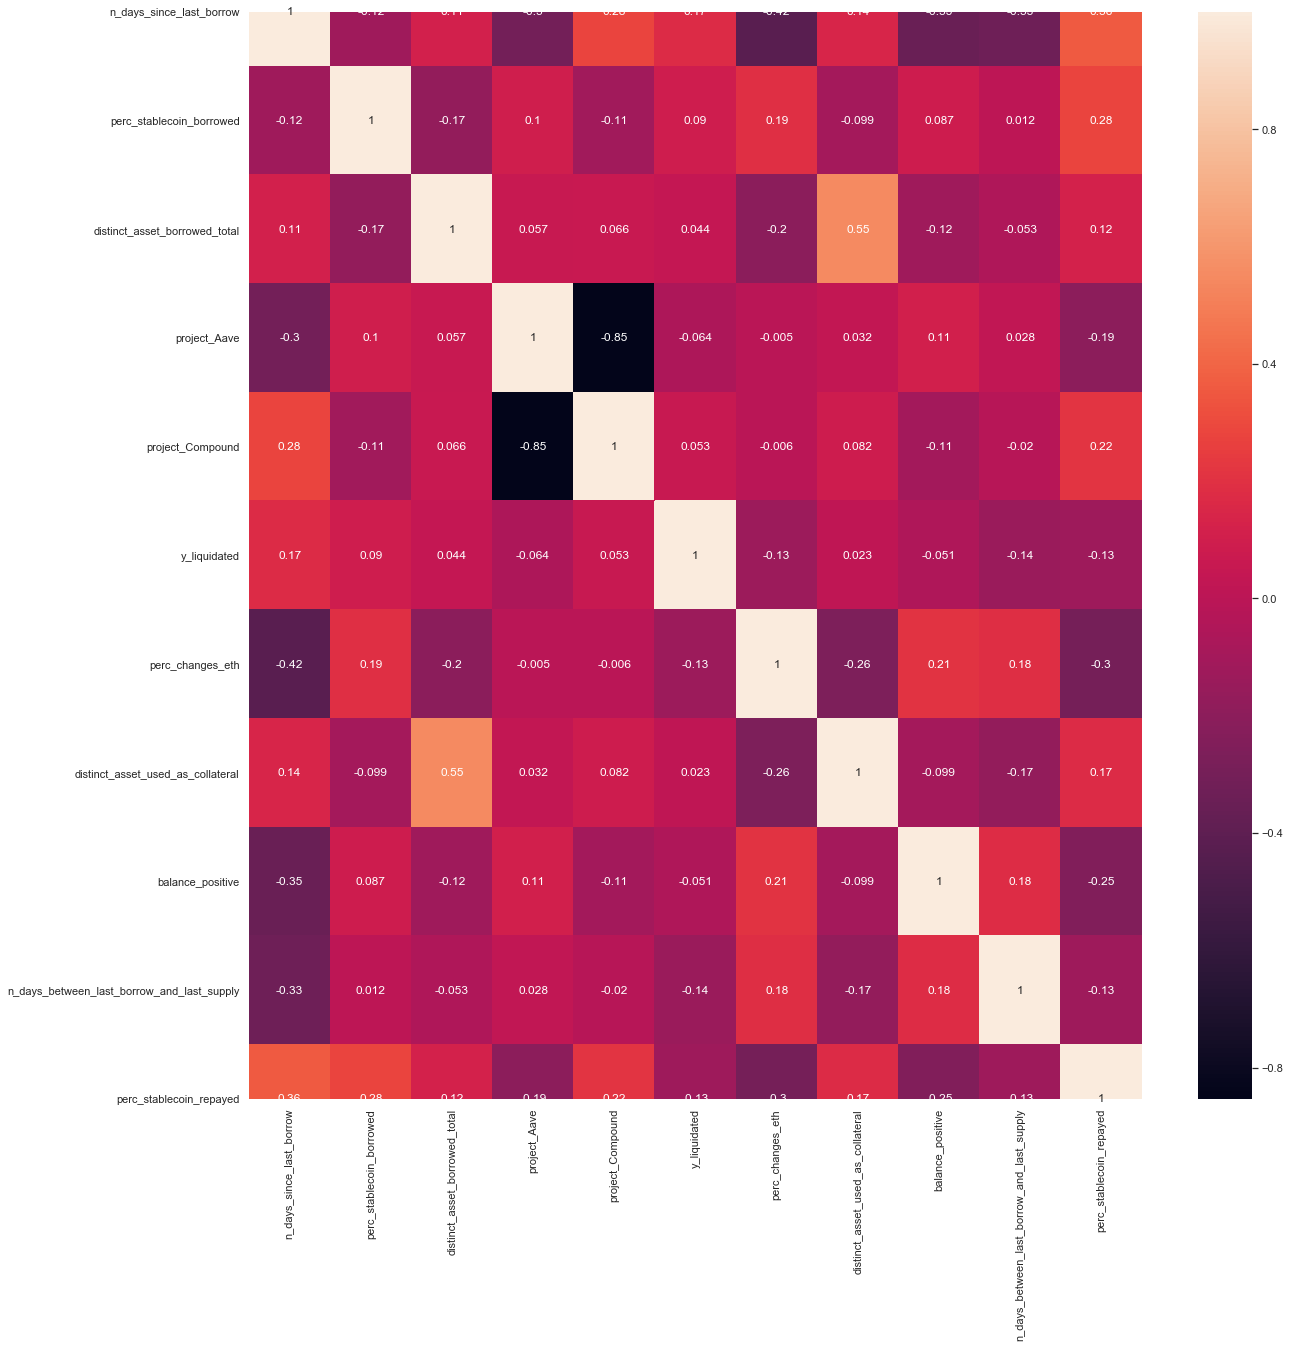

In [69]:
import seaborn as sns


sns.set(rc={'figure.figsize':(20,20)})
sns.heatmap(final_df.corr(), annot = True)

In [70]:
final_df.reset_index(inplace =True)

In [71]:
final_df = rem_col(final_df, 'n_days_since_last_borrow')

# Final Dataframe Statistics

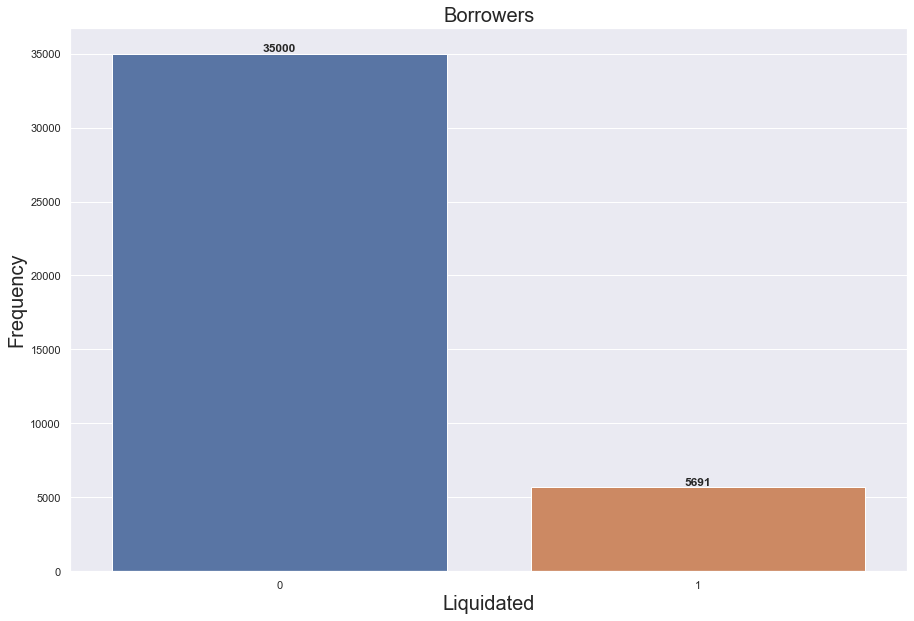

In [99]:
for_plot = final_df.groupby('y_liquidated').count()[['borrower']].reset_index()
for_plot = for_plot.rename(columns = {'borrower':'Frequency', 'y_liquidated':'Y'})
fig, ax = plt.subplots(1,1,figsize = (15,10))
ax = sns.barplot(x="Y", y="Frequency", data=for_plot)

ax.set_title("Borrowers", size = 20)
plt.xlabel("Liquidated", size = 20)
plt.ylabel("Frequency", size = 20)

ind = np.arange(2)
for i in range(2):
    plt.annotate(str(round(for_plot.loc[i]['Frequency'],1)), xy =(ind[i],for_plot.loc[i]['Frequency']), weight = 'bold', ha='center', va='bottom')
    
    
fig.savefig("final.png")

In [100]:
print("Unique Borrowers Aave:", final_df.project_Aave.sum())
print("Unique Borrowers Compound:", final_df.project_Compound.sum())
print("Unique Borrowers Compound and Aave:", final_df[(final_df.project_Compound == 1) & (final_df.project_Aave == 1)].shape[0])

Unique Borrowers Aave: 31890
Unique Borrowers Compound: 11182
Unique Borrowers Compound and Aave: 2381


## Divide Endogenous and Exogenous Variables

In [101]:
X = final_df.drop(['y_liquidated'], axis = 1).set_index('borrower')
y = final_df.set_index('borrower').y_liquidated

## Inference

In [102]:
import statsmodels.api as sm

X = sm.add_constant(X)

linear_model = sm.OLS(endog = y.values, exog = X).fit()

In [103]:
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     698.2
Date:                Sun, 09 Oct 2022   Prob (F-statistic):               0.00
Time:                        14:53:17   Log-Likelihood:                -11728.
No. Observations:               40691   AIC:                         2.348e+04
Df Residuals:                   40681   BIC:                         2.356e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                          0.1836      0.009     20.166      0.000       0.166       0.201
perc_stablecoin_borrowed                       0.2546      0.005     50.682      0.000       0.245       0.264
distinct_asset_borrowed_total                  0.0290      0.002     16.087      0.000       0.025       0.033
project_Aave                                  -0.0983      0.008    -12.721      0.000      -0.113      -0.083
project_Compound                               0.0327      0.007      4.586      0.000       0.019       0.047
perc_changes_eth                              -0.1867      0.004    -45.579      0.000      -0.195      -0.179
distinct_asset_used_as_collateral             -0.0069      0.001     -5.815      0.000      -0.009      -0.005
balance_positive                              -0.0472      0.004    -12.422      0.000      -0.055      -0.040
n_days_between_last_borrow_and_last_supply    -0.0005   1.66e-05    -27.394      0.000      -0.000      -0.000
perc_stablecoin_repayed                       -0.2514      0.004    -61.244      0.000      -0.259      -0.243
==============================================================================
Omnibus:                    12108.874   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            27567.747
Skew:                           1.740   Prob(JB):                         0.00
Kurtosis:                       5.039   Cond. No.                         866.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Interpration of Metrics:
    - Jarque Bera (JB) if high: sample data do not have a normal distribution
    - Durbin Watson: if = 2 means there is no autocorrelation (Good)

# Statistical Learning: Predictive Models

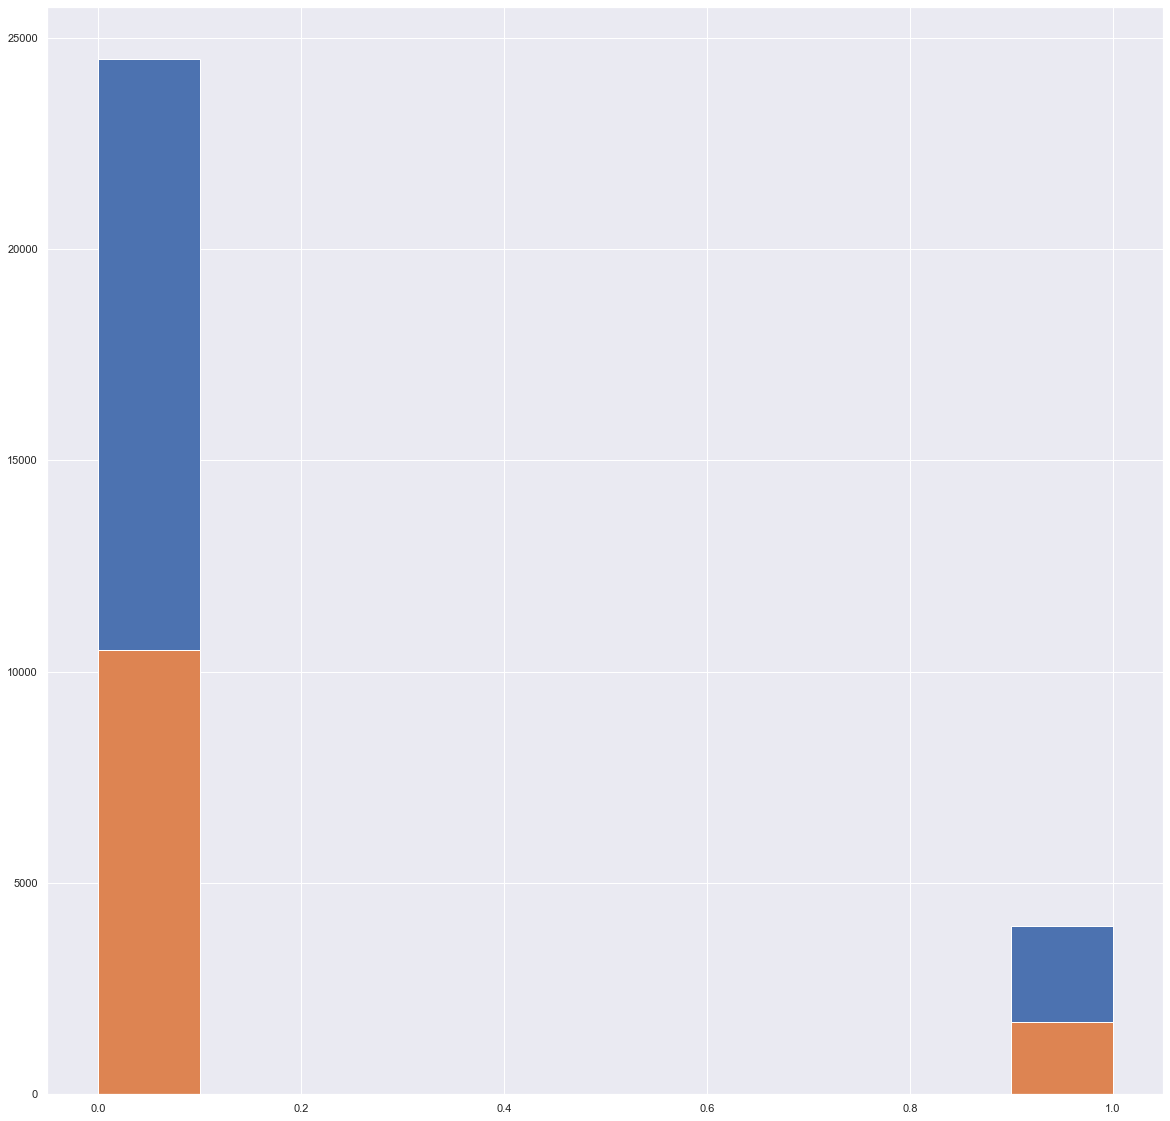

In [1082]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state= 42, stratify = final_df.y_liquidated.values, shuffle = True)

y_train.hist()
y_test.hist()
plt.show()

### Preprocessing

Given that the regressors are on different scales, we perform some preprocessing before applying our statistical methods. This will help in better estimate the coefficients in predicting and smooth the optimization, while the effect on statistical power is minimal.
It has to be noted that the same transformation that have to be applied on the training data need to be applied on the test set as well.

In [1083]:
final_df.columns

Index(['borrower', 'perc_stablecoin_borrowed', 'distinct_asset_borrowed_total',
       'project_Aave', 'project_Compound', 'y_liquidated', 'perc_changes_eth',
       'distinct_asset_used_as_collateral', 'balance_positive',
       'n_days_between_last_borrow_and_last_supply',
       'perc_stablecoin_repayed'],
      dtype='object')

In [1084]:
X.columns

Index(['const', 'perc_stablecoin_borrowed', 'distinct_asset_borrowed_total',
       'project_Aave', 'project_Compound', 'perc_changes_eth',
       'distinct_asset_used_as_collateral', 'balance_positive',
       'n_days_between_last_borrow_and_last_supply',
       'perc_stablecoin_repayed'],
      dtype='object')

In [1085]:
#Rescaling
rescale_features = {i:'avg' for i in X.columns[1:]} #remove dummies from here 

for (feature_name, rescale_method) in rescale_features.items():
    if rescale_method == 'minmax':
        _min = X_train[feature_name].min()
        _max = X_train[feature_name].max()
        scale = _max - _min
        shift = _min
    else:
        shift = X_train[feature_name].mean()
        scale = X_train[feature_name].std()
    if scale == 0.:
        del X_train[feature_name]
        del X_test[feature_name]
        print ('Feature %s was dropped because it has no variance' % feature_name)
    else:
        print ('Rescaled %s' % feature_name)
        X_train[feature_name] = (X_train[feature_name] - shift).astype(np.float64) / scale
        X_test[feature_name] = (X_test[feature_name] - shift).astype(np.float64) / scale

Rescaled perc_stablecoin_borrowed
Rescaled distinct_asset_borrowed_total
Rescaled project_Aave
Rescaled project_Compound
Rescaled perc_changes_eth
Rescaled distinct_asset_used_as_collateral
Rescaled balance_positive
Rescaled n_days_between_last_borrow_and_last_supply
Rescaled perc_stablecoin_repayed


<ipython-input-1085-0988b939118f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[feature_name] = (X_train[feature_name] - shift).astype(np.float64) / scale
<ipython-input-1085-0988b939118f>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[feature_name] = (X_test[feature_name] - shift).astype(np.float64) / scale


# Statistical Learning:

In [1086]:
"""
Auxiliary Functions
"""

def confusion_matrix_custom(y_test, y_pred):
    cm = pd.DataFrame(confusion_matrix(y_test, y_pred).T, index=[str(i+1) for i in range(2)], columns=[str(i+1) for i in range(2)])
    cm.index.name = 'Predicted'
    cm.columns.name = 'True'
    return cm

# 1. Logistic Regression

In [1087]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

def threshold_optimization(model, X_dev, y_dev, score = f1_score, show = False):
    y_pred_prob = model.predict_proba(X_dev)
    c = {}
    thre = 0
    minimo = 0
    for i in np.arange(0,1,0.01):
        y_pred = np.zeros(len(y_dev))
        y_pred[y_pred_prob[:,1] > i] = 1
        y_pred = y_pred.astype(int)
        c[i] = score(y_dev, y_pred)
        if c[i] > minimo:
            minimo = c[i]
            thre = i
    y_pred = np.zeros(len(y_dev))
    y_pred[y_pred_prob[:,1] > thre] = 1
    y_pred = y_pred.astype(int)
    if show:
        print("Threshold that should be used: ", thre)
        print("Best f1_score: ",c[thre])
    return (c[thre], thre, y_pred)


In [1101]:
def the_LR(X_train, X_test, y_train, y_test, show = True):
    print("Logistic Regression training..")
    base_clf = LogisticRegression(max_iter = 1e5)
    param_grid = {'C': [100, 50, 30, 10], #grid search on regularization parameters
                  'solver' : ['lbfgs', 'saga'],
                  'class_weight': ['balanced']
                 }
    search = GridSearchCV(base_clf, 
                          param_grid,
                          cv=5, 
                          scoring= 'f1_micro') 
    search.fit(X_train, y_train)
    clf_best = search.best_estimator_
    if show:
        print("Best Parameters chosen:")
        print(50*'-')
        print(clf_best.get_params(), search.best_score_)
    #fit on entire training data
    clf_best.fit(X_train, y_train)
    #predictions on dev data
    predictions_test = clf_best.predict(X_test)
    if show:
        print("Predictions on TEST SET:")
        print(50*'-')
        print(classification_report(y_test, predictions_test))
        print("With Thresholding")
    _, thre, predictions_test = threshold_optimization(clf_best, X_test, y_test, show = show)
    if show:
        print(classification_report(y_test, predictions_test))
        print("/n Confusion Matrix: /n")
        print(confusion_matrix_custom(y_test, predictions_test))
    print("Done")
    return clf_best, predictions_test

In [1102]:
the_lr, predictions_test_lr = the_LR(X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

Logistic Regression training..
Best Parameters chosen:
--------------------------------------------------
{'C': 50, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100000.0, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False} 0.7621034405058448
Predictions on TEST SET:
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.77      0.85     10501
           1       0.33      0.69      0.45      1707

    accuracy                           0.76     12208
   macro avg       0.64      0.73      0.65     12208
weighted avg       0.85      0.76      0.79     12208

With Thresholding
Threshold that should be used:  0.54
Best f1_score:  0.4642190416925949
              precision    recall  f1-score   support

           0       0.94      0.81      0

# 2. Random Forest Classifier

In [1104]:
from sklearn.ensemble import RandomForestClassifier

In [1110]:
def the_Random_Forest(X_train, X_test, y_train, y_test, show = True):
    
    print("Random Forest Training..")

    rc = RandomForestClassifier(bootstrap = True, class_weight = 'balanced', criterion = 'entropy', n_jobs = -1, 
                                 max_leaf_nodes = 20, min_samples_leaf = 20, n_estimators = 2000
                               )
    param_grid = {"min_samples_split": [2,3, 5],
                  "max_depth": [5, 7, 15]}

    gscv = GridSearchCV(rc, param_grid, cv = 5, n_jobs= -1, scoring = 'f1_micro')
    gscv.fit(X_train,y_train)
    rc_best = gscv.best_estimator_
    if show:
        print("Best Parameters chosen:")
        print(50*'-')
        print(rc_best.get_params(), gscv.best_score_)
    #fit on entire training data
    rc_best.fit(X_train, y_train)
    #predictions on real data
    predictions_test = rc_best.predict(X_test)
    if show:
        print("Predictions on DEV SET):")
        print(50*'-')
        print(classification_report(y_test, predictions_test))
        print("With Thresholding")
    _, thre, predictions_test = threshold_optimization(rc_best, X_test, y_test, show = show)
    if show:
        print(classification_report(y_test, predictions_test))
        print("/n Confusion Matrix: /n")
        print(confusion_matrix_custom(y_test, predictions_test))
    print("Done.")
    return rc_best, predictions_test


In [1112]:
the_rf, predictions_test_rf = the_Random_Forest(X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)



Random Forest Training..
Best Parameters chosen:
--------------------------------------------------
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'max_features': 'auto', 'max_leaf_nodes': 20, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 20, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 2000, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False} 0.8694306139837054
Predictions on DEV SET):
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.87      0.92     10501
           1       0.51      0.87      0.64      1707

    accuracy                           0.87     12208
   macro avg       0.74      0.87      0.78     12208
weighted avg       0.91      0.87      0.88     12208

With Thresholding
Threshold that should be used:  0.5

# 3. Boosting

In [1113]:
def the_GBC(X_train, X_dev, y_train, y_dev, show = True):
    
    print("Gradient Boosting Training..")
    
    gbc_classifier = GradientBoostingClassifier(learning_rate = 0.01, n_estimators= 2000, random_state=10)
    params_GBC = {
                'min_samples_split': [200, 300, 500], 
                  'min_samples_leaf': [50, 100],
                  'max_depth': [1,3, 5],
                    'max_features' : ['sqrt'],
                 "subsample": [0.8]} 
  
    gs_GBC = GridSearchCV(estimator = gbc_classifier, 
                          param_grid = params_GBC, 
                          scoring = 'f1_micro',
                          cv = 5)
    

    gs_GBC.fit(X_train, y_train)

    gbc_best = gs_GBC.best_estimator_
    if show:
        print("Best Parameters chosen:")
        print(50*'-')
        print(gbc_best.get_params(), gs_GBC.best_score_)
    #fit on entire training data
    gbc_best.fit(X_train, y_train)
    #predictions on real data
    predictions_dev = gbc_best.predict(X_dev)
    if show:
        print("Predictions on DEV SET):")
        print(50*'-')
        print(classification_report(y_dev, predictions_dev))
        print("With Thresholding")
    _, thre, predictions_dev = threshold_optimization(gbc_best, X_dev, y_dev, show = show)
    if show:
        print(classification_report(y_dev, predictions_dev))
        print("/n Confusion Matrix: /n")
        print(confusion_matrix_custom(y_dev, predictions_dev))
    print("Done.")
    return gbc_best, predictions_dev

In [1115]:
the_gbc, predictions_test_gbc = the_GBC(X_train = X_train, X_dev = X_test, y_train = y_train, y_dev = y_test)



Gradient Boosting Training..
Best Parameters chosen:
--------------------------------------------------
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 5, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 100, 'min_samples_split': 200, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 2000, 'n_iter_no_change': None, 'random_state': 10, 'subsample': 0.8, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False} 0.9317135423138139
Predictions on DEV SET):
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.97      0.96     10501
           1       0.80      0.65      0.71      1707

    accuracy                           0.93     12208
   macro avg       0.87      0.81      0.84     12208
weighted avg       0.92      0.93      0.92     12208
